#Classifying disease using Deep Learning

Deep learning proven to be superior in detecting and classifying disease using imagery data.

The project is about to automate the process of detecting and classifying chest disease and reduce the cost and time of detection. Dataset contains 133 images that belong to 4 classes.

*   Healthy
*   Covid-19
*   Bacterial Pneumonia
*   Viral Pneumonia


#IMPORT LIBRARIES AND DATASET

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
#This is custom dataset that contains Covid-19, Bacterial Pneumonia, Viral Pneumonia and normal person x-ray images


# Specify training data directory
XRay_Directory = '/content/drive/My Drive/Dataset'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['2', '0', '3', '1']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation 
image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(directory=XRay_Directory,target_size=(256,256),class_mode="categorical",batch_size=40,subset="training",shuffle=True)

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(directory=XRay_Directory,target_size=(256,256),class_mode="categorical",batch_size=40,subset="validation",shuffle=True)

Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images,train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_images[0]

array([[[0.40000004, 0.40000004, 0.40000004],
        [0.35686275, 0.35686275, 0.35686275],
        [0.36078432, 0.36078432, 0.36078432],
        ...,
        [0.54901963, 0.54901963, 0.54901963],
        [0.56078434, 0.56078434, 0.56078434],
        [0.5294118 , 0.5294118 , 0.5294118 ]],

       [[0.41960788, 0.41960788, 0.41960788],
        [0.3803922 , 0.3803922 , 0.3803922 ],
        [0.40000004, 0.40000004, 0.40000004],
        ...,
        [0.5529412 , 0.5529412 , 0.5529412 ],
        [0.5529412 , 0.5529412 , 0.5529412 ],
        [0.5647059 , 0.5647059 , 0.5647059 ]],

       [[0.427451  , 0.427451  , 0.427451  ],
        [0.38823533, 0.38823533, 0.38823533],
        [0.4039216 , 0.4039216 , 0.4039216 ],
        ...,
        [0.5764706 , 0.5764706 , 0.5764706 ],
        [0.5568628 , 0.5568628 , 0.5568628 ],
        [0.5647059 , 0.5647059 , 0.5647059 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [ ]:
#Name the labels
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

##VISUALIZE DATASET

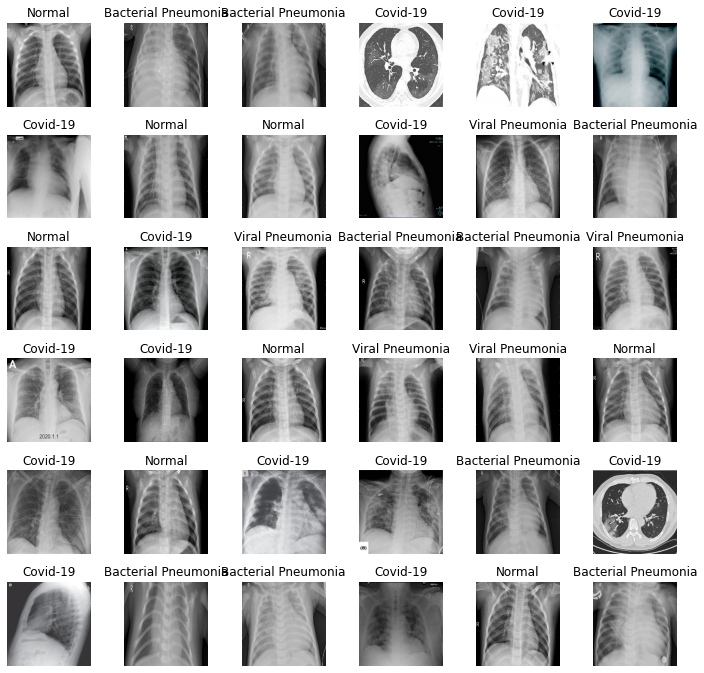

In [ ]:
# Create a grid of 36 images along with their corresponding labels

fig,ax = plt.subplots(6,6,figsize=(12,12))
ax = ax.ravel()

for i in np.arange(0,36):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.4)

##IMPORT MODEL WITH PRETRAINED WEIGHTS

In [ ]:
base_model = ResNet50(weights="imagenet",include_top=False,input_tensor=Input(shape=(256,256,3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#freezing the model upto the last stage - 4 and re-training stage -5 
for layer in base_model.layers[:-10]:
  layers.trainable = False

#BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256,activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(256,activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(4,activation="softmax")(head_model)

model = Model(inputs = base_model.input, outputs=head_model)

In [ ]:
model.compile(loss= "categorical_crossentropy",optimizer= optimizers.RMSprop(lr=1e-4, decay=1e-6), metrics=["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weight.hdf5", verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(directory=XRay_Directory,target_size=(256,256),class_mode="categorical",batch_size=4,subset="training",shuffle=True)

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(directory=XRay_Directory,target_size=(256,256),class_mode="categorical",batch_size=4,subset="validation",shuffle=True)

Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=train_generator.n//4,epochs=25,validation_data=val_generator,validation_steps=val_generator.n//4,callbacks=[earlystopping,checkpointer])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.9169 - accuracy: 0.6355
Epoch 00001: val_loss improved from inf to 8.70353, saving model to weight.hdf5
107/107 [==============================] - 15s 144ms/step - loss: 0.9169 - accuracy: 0.6355 - val_loss: 8.7035 - val_accuracy: 0.2500
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8785
Epoch 00002: val_loss did not improve from 8.70353
107/107 [==============================] - 13s 120ms/step - loss: 0.4629 - accuracy: 0.8785 - val_loss: 32.6548 - val_accuracy: 0.2500
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8855
Epoch 00003: val_loss did not improve from 8.70353
107/107 [==============================] - 13s 118ms/step - loss: 0.3452 - accuracy: 0.8855 - val_loss: 24.1061 - val_accuracy: 0.2500
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9720
Epoch 00004: val_loss did not 

#EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

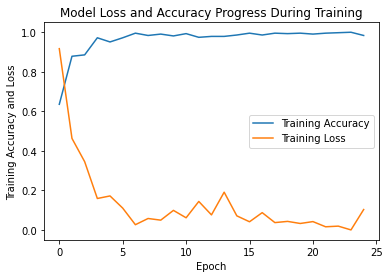

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(["Training Accuracy", "Training Loss"])

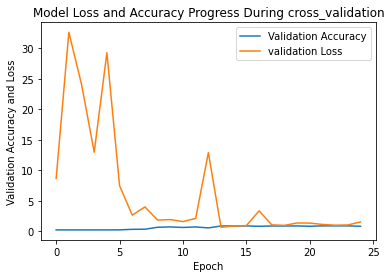

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title('Model Loss and Accuracy Progress During cross_validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy and Loss')
plt.legend(["Validation Accuracy", "validation Loss"])

In [ ]:
# Specify testing data directory
test_Directory = '/content/drive/My Drive/Test'

In [ ]:
os.listdir(test_Directory)

['3', '0', '2', '1']

In [ ]:
test_gen = ImageDataGenerator(rescale= 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40,shuffle=True,directory=test_Directory,target_size=(256,256),class_mode="categorical")

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator, steps= test_generator.n//4, verbose=1)
print('Accuracy Test : {}'.format(evaluate[1]))

 1/10 [==>...........................] - 0s 12ms/step - loss: 5.3299 - accuracy: 0.7250
Accuracy Test : 0.7250000238418579


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_Directory))):
  for item in os.listdir(os.path.join(test_Directory,str(i))):
    img= cv2.imread(os.path.join(test_Directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
original

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
score

0.7

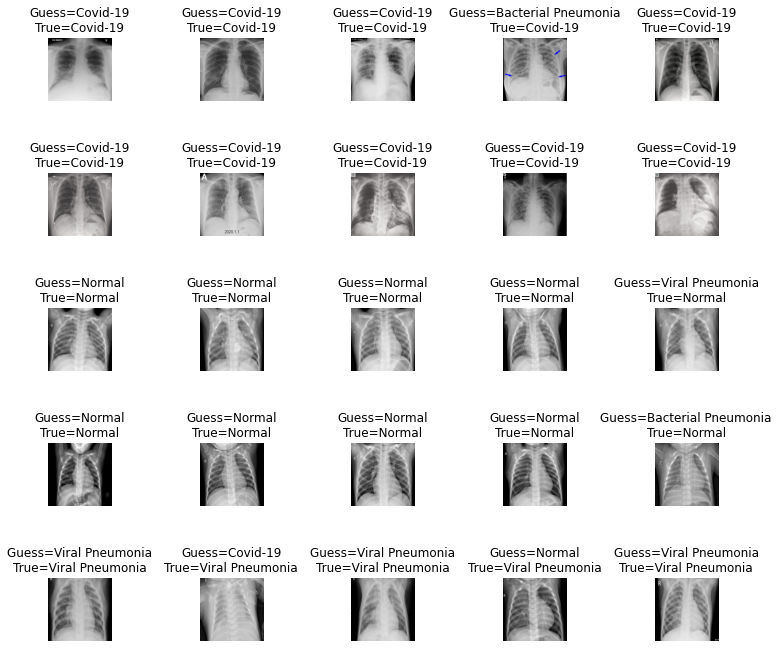

In [ ]:

fig, axes = plt.subplots(5, 5, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.4) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.62      0.80      0.70        10
           2       0.62      0.50      0.56        10
           3       0.75      0.60      0.67        10

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.69        40
weighted avg       0.70      0.70      0.69        40

